# Examples of Continuous Wavelet Transform (CWT) and Wavelet Transform Coherence (WTC)

Author: Patrice Fortin

Date: 2025-01-06

The following Jupyter Notebook gives code examples for inspecting the internals of the Wavelet Transform Coherence (WTC) by showing figures of different steps of the computation.

The figures can be used to visually inspect the differences between choices of parameters, and libraries.

HyPyP is expected to use Pywavelets as a default implementation. It is the recommended library to use for wavelet in python, and the one that offers the most flexibility. The Pywavelets library is the only one expected to be used in production code.

But, for the sake of validating the HyPyP implementation of WTC, 3 different libraries have been explored.


| Library | Runtime | Details |
| - | - | - |
| Pywavelets | python | The default. Should always be used for production code |
| Pycwt | python | Based on matlab's code |
| WaveletCoherence | matlab | Calls matlab engine |



## Load libraries


In [1]:
import numpy as np
from typing import Iterator, Tuple
import matplotlib.pyplot as plt

In [3]:
# This is useful for developement. Every libraries loaded after this will have changes relected without restarting the kernel
%load_ext IPython.extensions.autoreload
%autoreload 2

from hypyp.wavelet import BaseWavelet, ComplexMorletWavelet, ComplexGaussianWavelet, CWT, CoherenceDataFrame, PairSignals
from hypyp.signal import SyntheticSignal

The IPython.extensions.autoreload extension is already loaded. To reload it, use:
  %reload_ext IPython.extensions.autoreload


## Define the wavelets

We prepare a list of wavelets to be compared. We set the same period_range for every wavelet.

Disabling the caching on wavelets is not mandatory here, but in the view that this code serves as an example, if one modifies this and reuse the same wavelet in different places without considering the fact that it caches results, one might see unexpected behaviour.

In [4]:
wavelet_kwargs = dict(disable_caching=True, frequency_range=(1, 30))

wavelets = [
    ComplexMorletWavelet(bandwidth_frequency=2, center_frequency=0.2, **wavelet_kwargs), # this one has very low frequency, to show how digital artifacts would look like
    ComplexMorletWavelet(bandwidth_frequency=2, center_frequency=1, **wavelet_kwargs),
    ComplexMorletWavelet(bandwidth_frequency=2, center_frequency=2, **wavelet_kwargs),
    ComplexMorletWavelet(bandwidth_frequency=2, center_frequency=5, **wavelet_kwargs),

    ComplexGaussianWavelet(degree=2, **wavelet_kwargs),
    ComplexGaussianWavelet(degree=3, **wavelet_kwargs),
    ComplexGaussianWavelet(degree=4, **wavelet_kwargs),
    ComplexGaussianWavelet(degree=5, **wavelet_kwargs),
]



Prepare a python iterator to easily loop over each wavelet and have a handy ax object for grid plotting.

In [5]:
def wavelets_plot_iterator() -> Iterator[Tuple[BaseWavelet, plt.Figure]]:
    cols = 4
    rows = int(np.ceil(len(wavelets) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
    axes = np.atleast_2d(axes)
    for i, wavelet in enumerate(wavelets):
        row = i // cols
        col = i % cols
        ax = axes[row][col]
        yield wavelet, ax


### Mother wavelets

Let's compare mother wavelets. The x axis differs between libraries because of implementation details.

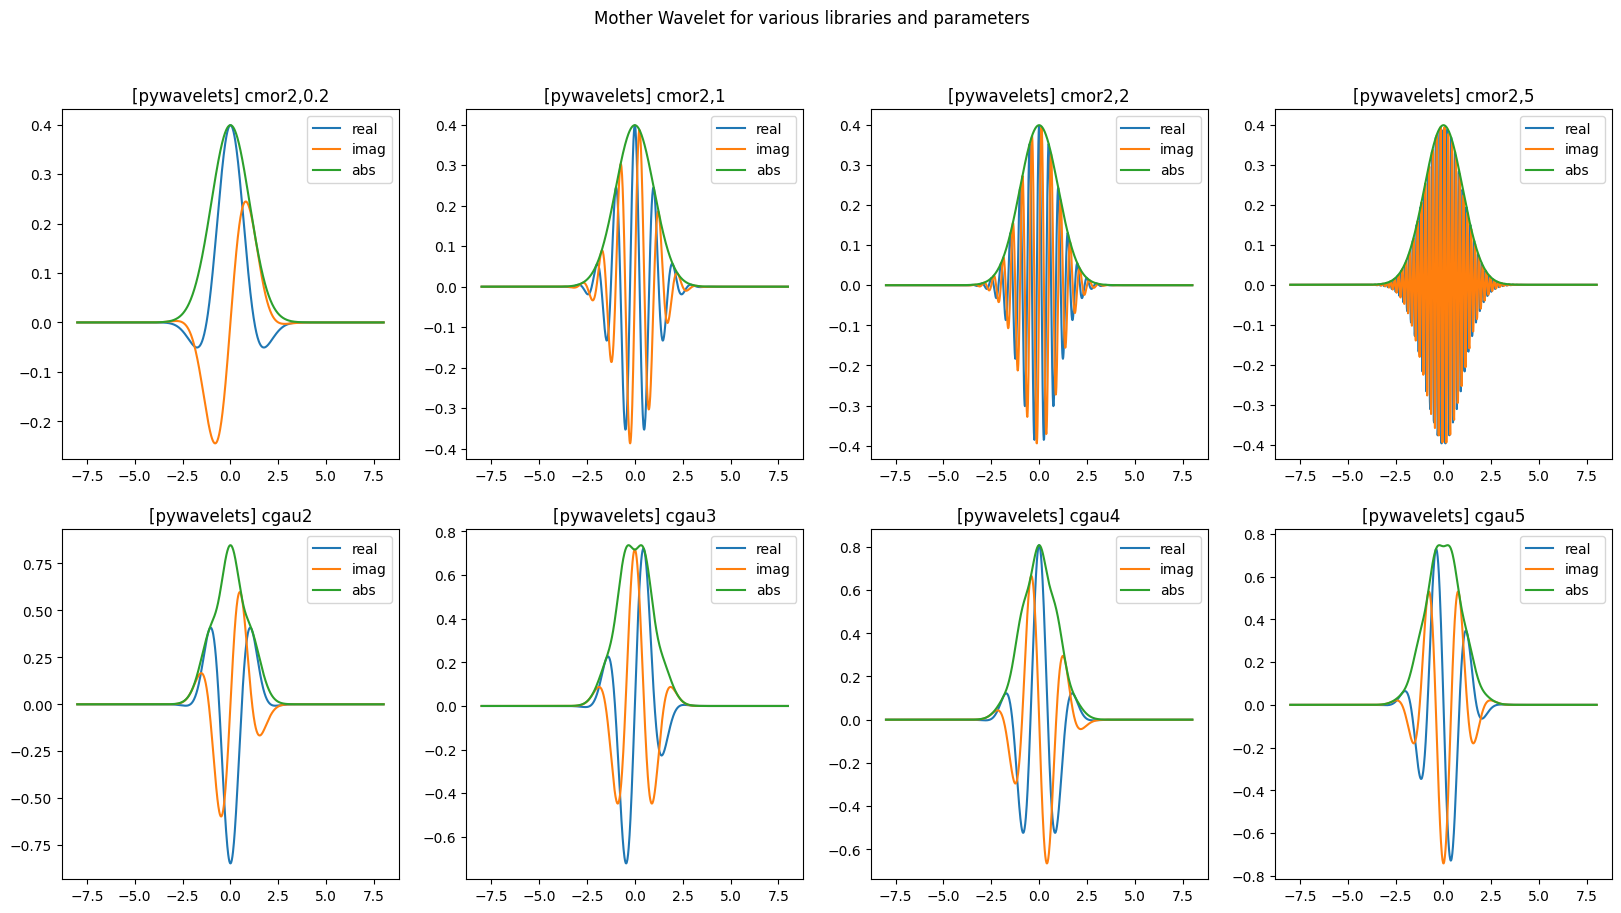

In [6]:

for wavelet, ax in wavelets_plot_iterator():
    wavelet.plot_mother_wavelet(ax=ax)
    ax.set_title(f'[{wavelet.wavelet_library}] {wavelet.wavelet_name}')
_ = ax.get_figure().suptitle('Mother Wavelet for various libraries and parameters')


### Generate synthetic signals

Prepare a pair of signals signals to be used in the Continuous Wavelet Transforms

In [8]:
t_max = 10
sfreq = 100
N = t_max * sfreq
x = np.linspace(0, t_max, N)

signal1 = SyntheticSignal(duration=t_max, n_points=N)
signal1.add_chirp(3, 10)
y1 = signal1.y
y2 = np.flip(y1)

pair = PairSignals(x, y1, y2, label_ch1='chirp 1', label_ch2='chirp 2')



Visualize the 2 signals


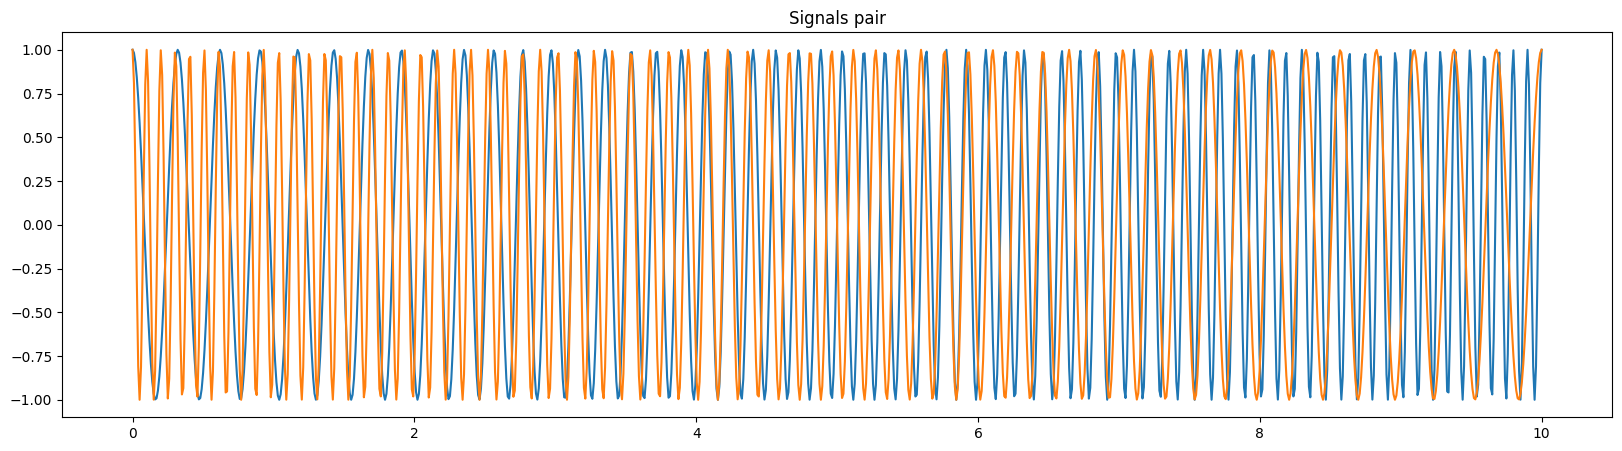

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(pair.x, pair.y1)
ax.plot(pair.x, pair.y2)
plt.title('Signals pair')
plt.show()


# Continuous Wavelet Transform (CWT)

We run the Continuous Wavelet Transform on both channels of the pair and visually inspect the results for every wavelet choices.

The darker area correspond to the Cone of Influence, for which periods greater than a certain value are more subject to artifacts. 

**NOTE: The computation of the Cone of Influence in the pywavelets should be reviewed for validity.**


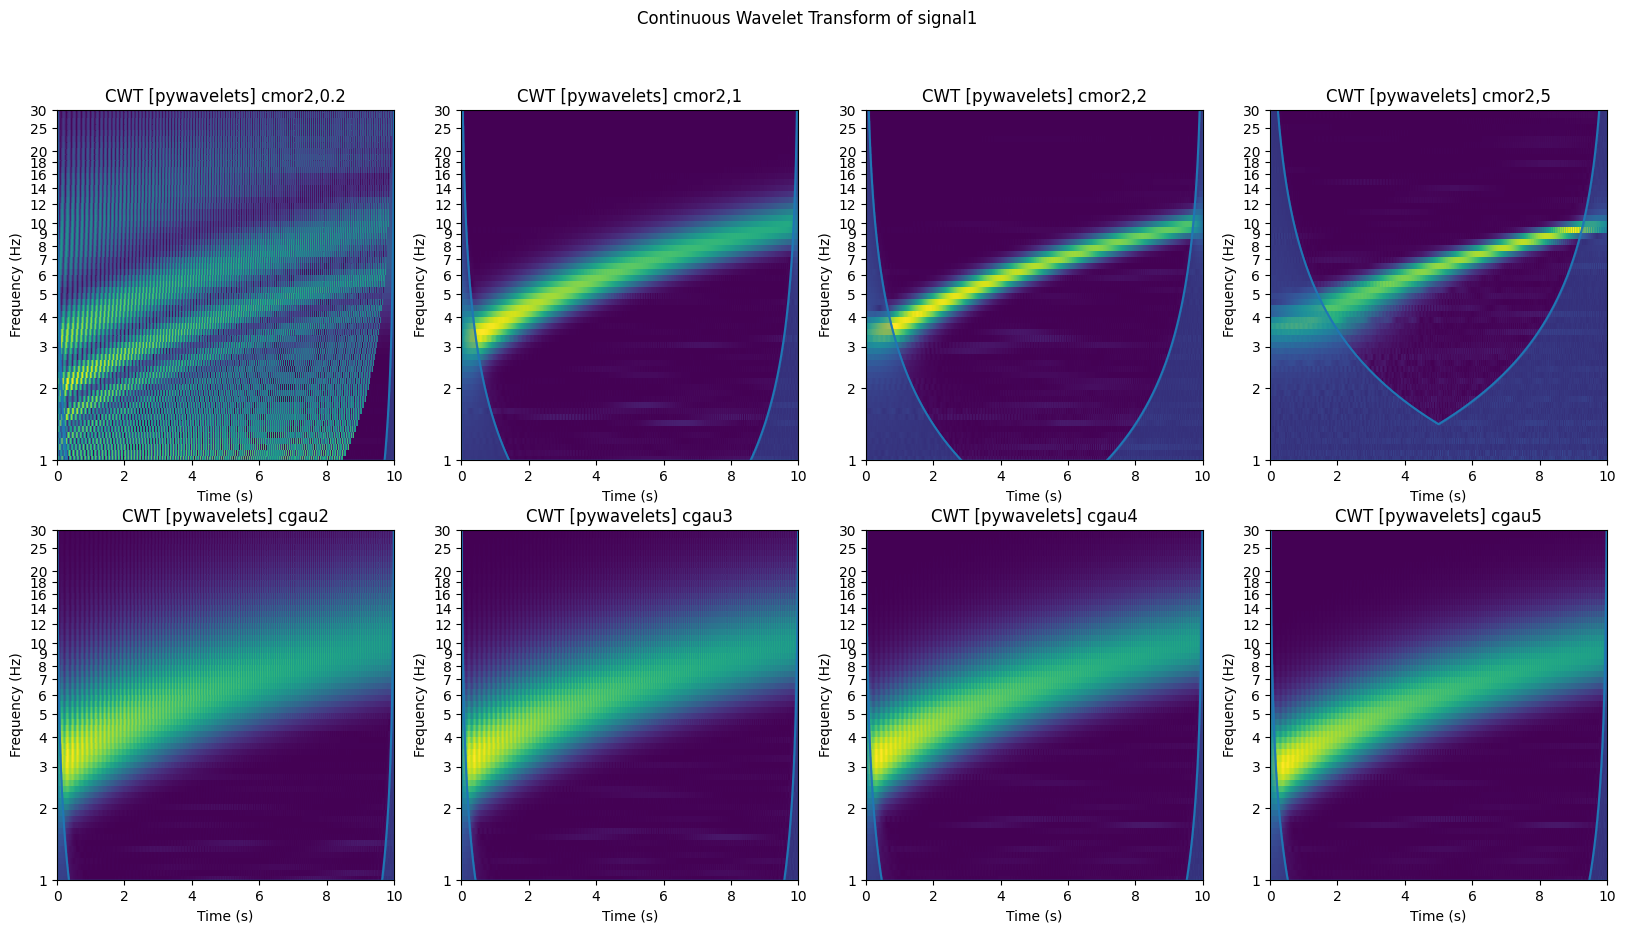

In [10]:
for wavelet, ax in wavelets_plot_iterator():
    cwt = wavelet.cwt(pair.y1, pair.dt)
    cwt.plot(ax=ax, show_colorbar=False)
    ax.set_title(f'CWT [{wavelet.wavelet_library}] {wavelet.wavelet_name}')
    ax.get_figure().suptitle('Continuous Wavelet Transform of signal1')
plt.show()



In [ ]:


for wavelet, ax in wavelets_plot_iterator():
    cwt = wavelet.cwt(pair.y2, pair.dt)
    cwt.plot(ax=ax, show_colorbar=False)
    ax.set_title(f'CWT [{wavelet.wavelet_library}] {wavelet.wavelet_name}')
    ax.get_figure().suptitle('Continuous Wavelet Transform of signal2')
plt.show()

## Compare smoothed CWTs


We explore the smooting of the the CWT. The weights of the CWT are smooted both in time and in frequency. 

The code below replicates the implementation details in the `BaseWavelet` class.

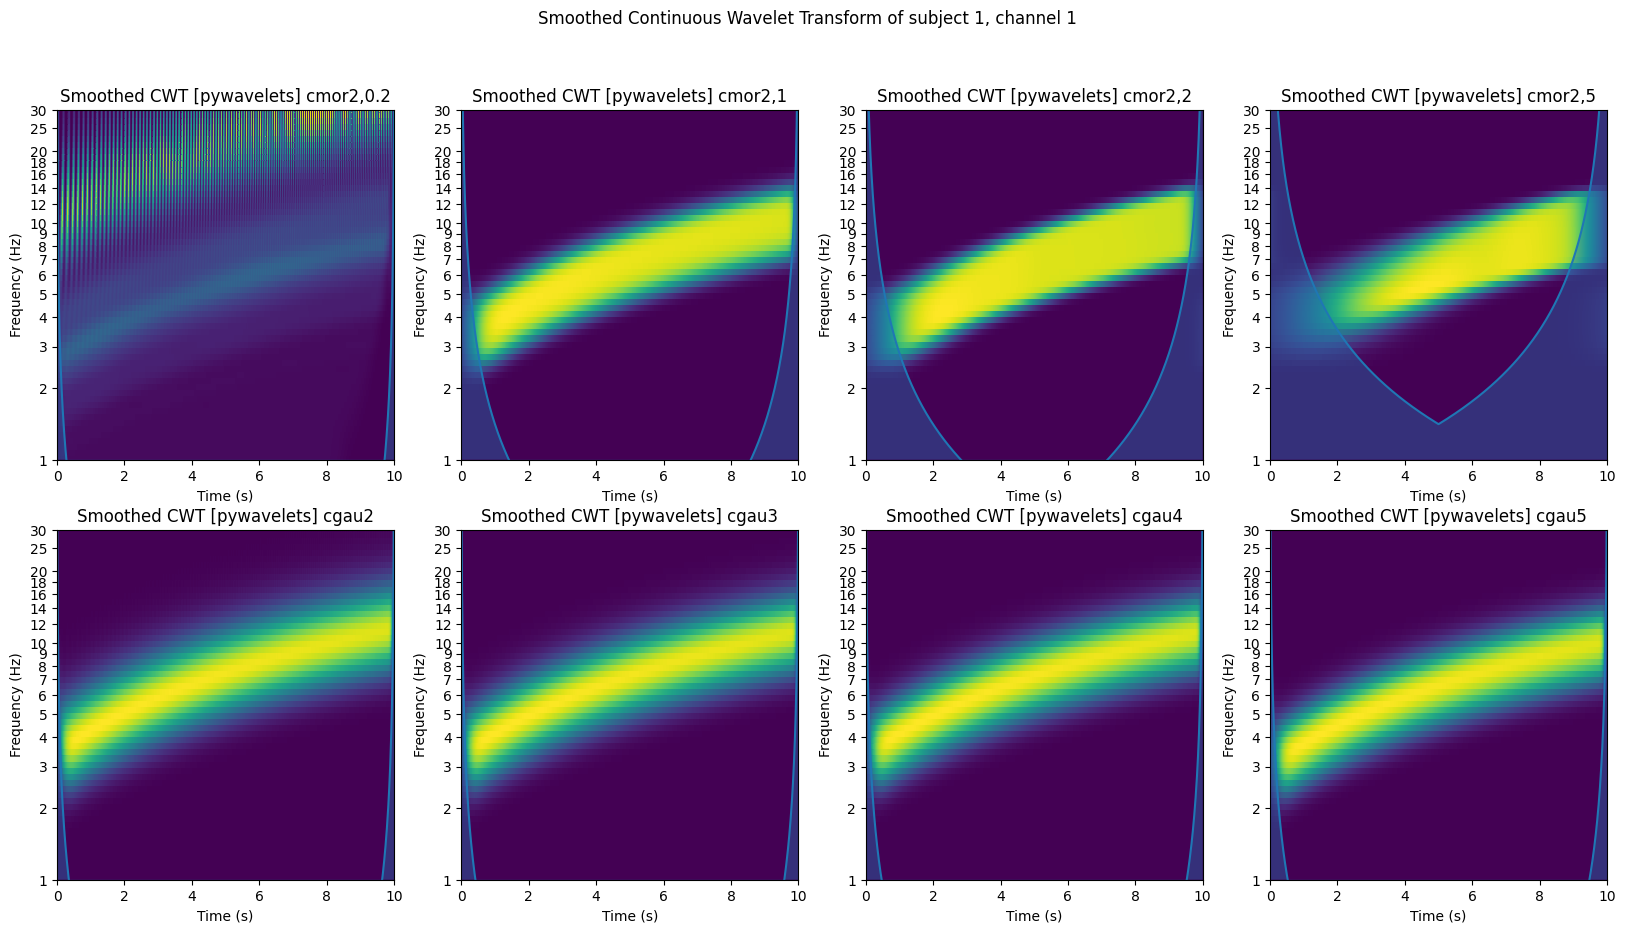

In [ ]:
for wavelet, ax in wavelets_plot_iterator():
    cwt = wavelet.cwt(pair.y1, pair.dt)

    scales = np.ones([1, len(pair.y1)]) * cwt.scales[:, None]
    smooted = wavelet.smoothing(np.abs(cwt.W) ** 2 / scales, cwt.dt, cwt.scales)
    cwt_smoothed = CWT(smooted**2, cwt.times, cwt.scales, cwt.periods, cwt.coi)
    cwt_smoothed.plot(ax=ax, show_colorbar=False)
    ax.set_title(f'Smoothed CWT [{wavelet.wavelet_library}] {wavelet.wavelet_name}')
    ax.get_figure().suptitle('Smoothed Continuous Wavelet Transform of subject 1, channel 1')
plt.show()



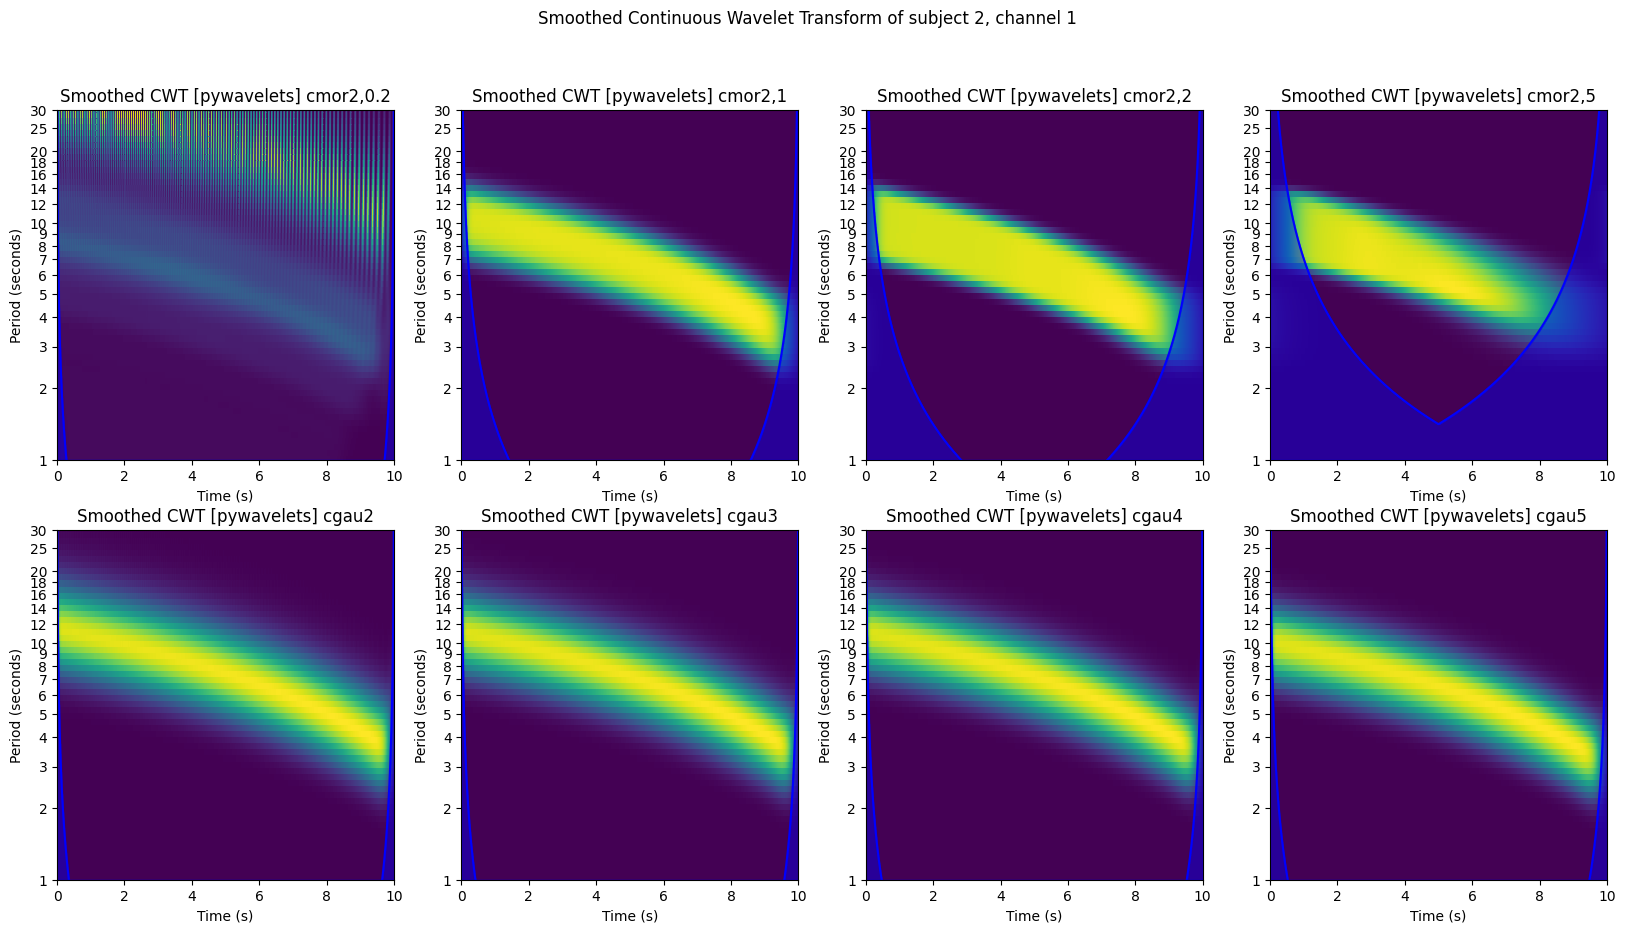

In [ ]:
for wavelet, ax in wavelets_plot_iterator():
    cwt = wavelet.cwt(pair.y2, pair.dt)

    scales = np.ones([1, len(pair.y2)]) * cwt.scales[:, None]
    smooted = wavelet.smoothing(np.abs(cwt.W) ** 2 / scales, cwt.dt, cwt.scales)
    cwt_smoothed = CWT(smooted**2, cwt.times, cwt.scales, cwt.periods, cwt.coi)
    cwt_smoothed.plot(ax=ax, show_colorbar=False)
    ax.set_title(f'Smoothed CWT [{wavelet.wavelet_library}] {wavelet.wavelet_name}')
    ax.get_figure().suptitle('Smoothed Continuous Wavelet Transform of subject 2, channel 1')
plt.show()




## Compare Wavelet Transform Coherence (WTC)

Now that we can trust our CWT and smoothing, we compare the WTC results for each wavelet.

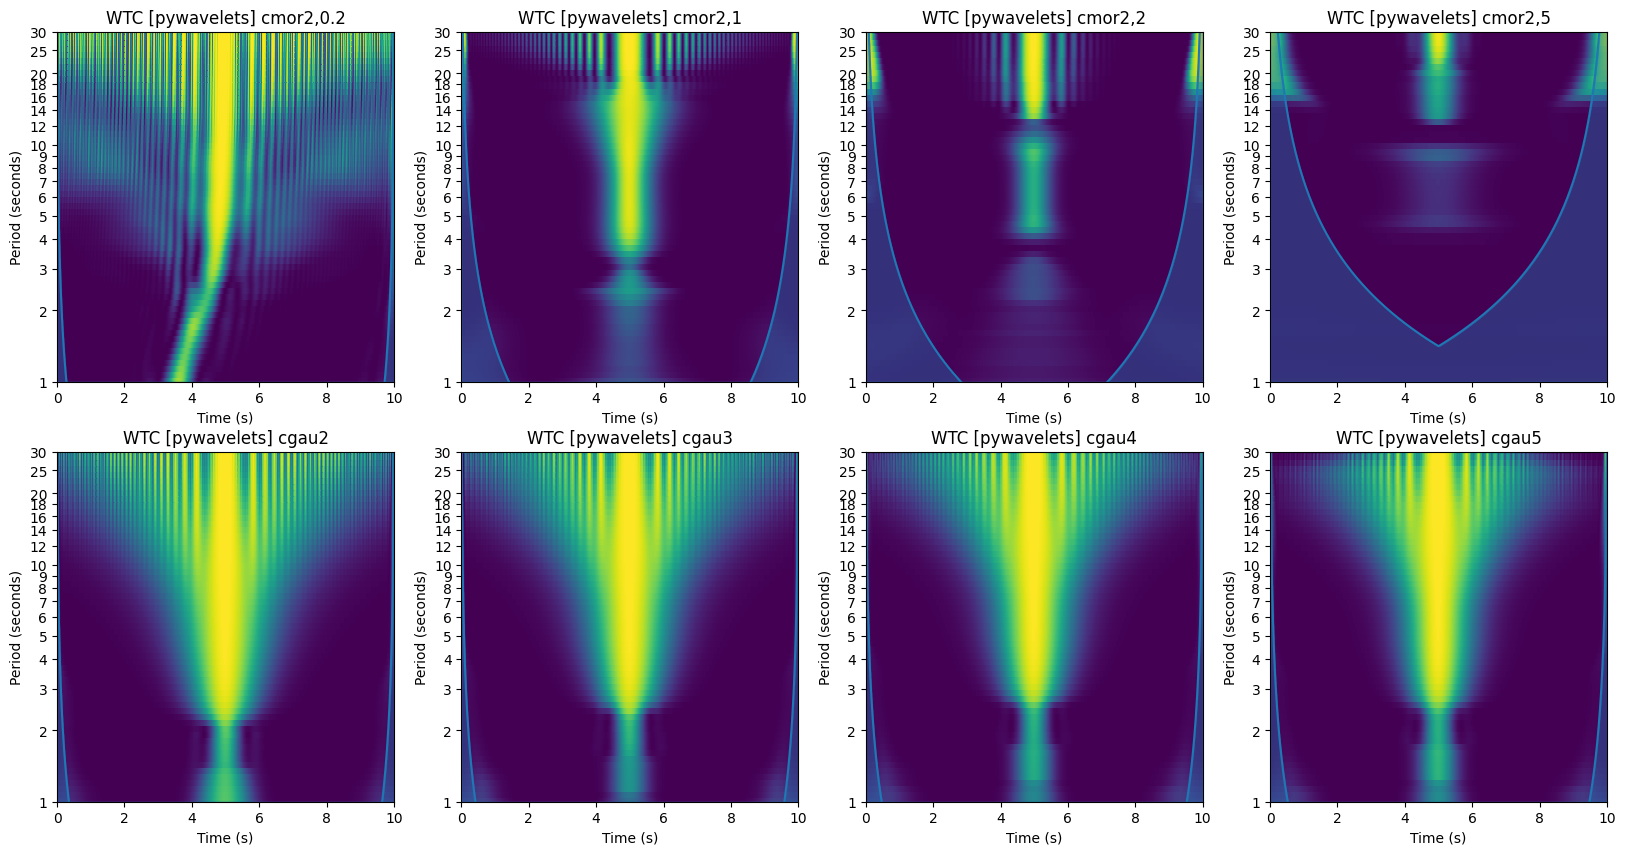

In [ ]:
for wavelet, ax in wavelets_plot_iterator():
    wtc = wavelet.wtc(pair)
    wtc.plot(ax=ax, show_colorbar=False)
    ax.set_title(f'WTC [{wavelet.wavelet_library}] {wavelet.wavelet_name}')
plt.show()


## Time and frequency segmentation

When doing statistical analysis, multiple recordings of dyads are necessary. For each recording, a set of tasks are usually given, and can be recovered by events in the fNIRS recording file. 

These tasks may be recurring tasks, and have a different duration each time. A robust analysis should weight each recording by its duration.

Also, recordings can present a number of signal issues, either motion artifacts that cannot be filtered, or a connectivity failing on a specific channel, to name a few. To avoid excluding channels with punctual invalid data, a signal on a channel can be splitted in segments and the WTC will be computed to the matching segment of other channels. This will result of multiple segments of smaller duration. We also need to weight accordingly.

It can also be useful to split the resulting data into periods slices, to find the most "coherent" period ranges.

In order to have a balanced weight and period slices, once the WTC has been computed on a channel pair, we can split the WTC matrix in a grid.

The figure below explicitly shows the grid for a computed WTC.

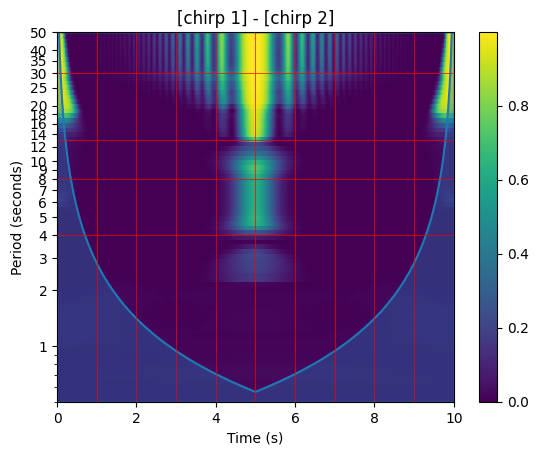

In [ ]:
wavelet = ComplexMorletWavelet(bandwidth_frequency=2, center_frequency=2, frequency_range=(0.5, 50), disable_caching=True)
bin_seconds = 1
frequency_cuts = [0.5, 4, 8, 13, 30, 100]
period_cuts = 1 / np.array(frequency_cuts)
wtc = wavelet.wtc(pair, bin_seconds, period_cuts=period_cuts)
fig = wtc.plot()



Each bin correspond to one row in a pandas DataFrame


In [ ]:
wtc.to_frame()


,dyad,is_intra,is_intra_of,is_shuffle,subject1,subject2,roi1,roi2,channel1,channel2,task,epoch,section,bin,coherence,coherence_masked,bin_time_range,bin_period_range,wavelet_library,wavelet_name
0,,False,0,False,,,,,chirp 1,chirp 2,,0,0,0,0.132057,0.258953,0-1,0.0-0.2,pywavelets,"cmor2,2[win:0.6]"
1,,False,0,False,,,,,chirp 1,chirp 2,,0,0,1,NaN,0.977273,0-1,0.3-2.0,pywavelets,"cmor2,2[win:0.6]"
2,,False,0,False,,,,,chirp 1,chirp 2,,0,0,2,0.004478,0.000000,1-2,0.0-0.2,pywavelets,"cmor2,2[win:0.6]"
3,,False,0,False,,,,,chirp 1,chirp 2,,0,0,3,NaN,0.659933,1-2,0.3-2.0,pywavelets,"cmor2,2[win:0.6]"
4,,False,0,False,,,,,chirp 1,chirp 2,,0,0,4,0.024480,0.000000,2-3,0.0-0.2,pywavelets,"cmor2,2[win:0.6]"
5,,False,0,False,,,,,chirp 1,chirp 2,,0,0,5,0.003909,0.410774,2-3,0.3-2.0,pywavelets,"cmor2,2[win:0.6]"
6,,False,0,False,,,,,chirp 1,chirp 2,,0,0,6,0.088161,0.000000,3-4,0.0-0.2,pywavelets,"cmor2,2[win:0.6]"
7,,False,0,False,,,,,chirp 1,chirp 2,,0,0,7,0.006197,0.248316,3-4,0.3-2.0,pywavelets,"cmor2,2[win:0.6]"
8,,False,0,False,,,,,chirp 1,chirp 2,,0,0,8,0.370247,0.000000,4-5,0.0-0.2,pywavelets,"cmor2,2[win:0.6]"
9,,False,0,False,,,,,chirp 1,chirp 2,,0,0,9,0.035792,0.127666,4-5,0.3-2.0,pywavelets,"cmor2,2[win:0.6]"
